In [1]:
import io                     # <-- to hold the PNG in RAM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from pyfonts import load_google_font

plt.rcParams['font.family'] = ['Open Sans']
plt.rcParams['font.weight'] = "medium"

output = rf"D:\World Bank\Data-Portal-Brief-Generator\Graphs" 

bold_font = load_google_font("Open Sans", weight="bold")
semibold_font = load_google_font("Open Sans", weight="medium")
legend_font = load_google_font("Open Sans", weight="medium")
legend_font.set_size(13)

colors_by_component = {
    "Education":{"text":"#e95d4e","line":"#0077b6"},
    "Health":{"text":"#bb0089","line":"#00b4d8"},
    "Labor":{"text":"#007bac","line":"#90e0ef"},
}

def generate_random_list(len=3):
    random_sum = 0
    while random_sum!=1:
        random_numbers = np.random.dirichlet(np.ones(len), size=1)[0]
        random_sum = sum(random_numbers)

    return random_numbers

def plot_hci_stage(
    x_main: float,
    x_top95: float,
    x_region: float,
    x_income: float,
    components: tuple[float, float, float],
    component_labels: tuple[str, str, str],
    title: str,
    *,
    ax=None,
    xlim: tuple[float, float] = (0, 1),
    show_value_label: bool = True,
    line_y_positions: tuple[float, float] = (0.0, -.15),
    scatter_styles: dict | None = None,
    segment_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  # red blue yellow
    figsize: tuple[int, int] = (5, 1.5),
):
    """Plot a two‑line decomposition chart that visually mimics the reference image.

    Parameters
    ----------
    x_main, x_top95, x_region
        Horizontal positions of the *main*, *top 95‑th percentile*, and *region* points.
    components
        Fractions that split the distance between *main* and *top95* into three
        coloured segments. Must each be in ``[0, 1]`` and sum to ``1``.
    xlim
        Horizontal axis limits.  Default ``(0, 1)`` to match the baseline in the
        reference graphic.
    show_value_label
        Whether to draw the numeric value of ``x_main`` above its marker.
    line_y_positions
        ``(y_scatter, y_decomposition)`` – vertical positions of the two
        horizontal baselines.
    scatter_styles
        Optional dict that can override marker attributes for
        ``{"main": {…}, "top95": {…}, "region": {…}}``.
    segment_colors
        Colours for the three decomposition segments (left→right).
    figsize
        Size of the figure.
    """

    # ------------------------------------------------------------------
    # validation
    # if len(components) != 3:
    #     raise ValueError("components must be a tuple of exactly three values")
    if any(c < 0 or c > 1 for c in components):
        raise ValueError("each component fraction must lie in [0, 1]")
    if abs(sum(components) - 1) > 1e-6:
        raise ValueError("components must sum to 1 (within tolerance)")

    y_scatter, y_decomp = line_y_positions

    # ------------------------------------------------------------------
    # default marker styles (tuned to resemble the screenshot)
    default_styles = {
        "main": dict(
            marker="o",
            s=300,
            color="#E95D4E",  
            edgecolors="#E95D4E",
            linewidths=2,
            zorder=4,
        ),
        "top95": dict(
            marker="o",  # pentagon
            s=300,
            color="#FAC723",   # yellow fill
            edgecolors=None,
            linewidths=1.5,
            zorder=4,
        ),
        "region": dict(
            marker="|",
            s=300,
            facecolors="#E95D4E",  # purple fill
            edgecolors=None,
            linewidths=2.5,
            zorder=4,
        ),
        "income": dict(
            marker="o",
            s=300,
            facecolors="#0CB2AF",
            edgecolors=None,
            linewidths=2.5,
            zorder=4,
        ),

    }

    if scatter_styles:
        # allow user overrides on a key‑by‑key basis
        for key, overrides in scatter_styles.items():
            default_styles.setdefault(key, {}).update(overrides)

    # ------------------------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    # top & bottom baselines (subtle grey)
    ax.hlines(y_scatter, *xlim, color="#f3f3f3", lw=20, zorder=-2)
    # ax.hlines(y_decomp, *xlim, color="black", lw=1)

    # scatter markers
    ax.scatter([x_main], [y_scatter], **default_styles["main"])
    ax.scatter([x_top95], [y_scatter], **default_styles["top95"])
    ax.scatter([x_region], [y_scatter], **default_styles["region"])
    ax.scatter([x_income], [y_scatter], **default_styles["income"])

    # numeric label above the *main* circle
    if show_value_label:
        for x in [x_main, x_top95, x_income]:
            ax.annotate(
                f"{x:.2f}",
                xy=(x, y_scatter),
                xytext=(0, 14),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=semibold_font,
                fontsize=12,
            )
        ax.annotate(
            f"{x_region:.2f}",
            xy=(x_region, y_scatter),
            xytext=(0, -25),
            textcoords="offset points",
            ha="center",
            va="bottom",
            font=semibold_font,
            fontsize=10,
        )


    # Distance to regional avg
    if x_region>x_main:
        x0 = x_main
        x1 = x_region
    else:
        x0 = x_region
        x1 = x_main

    ax.hlines(
        0,
        x0,
        x1,
        color=default_styles["region"]["facecolors"],
        lw=2.5,
        capstyle="butt",
        zorder=3,
    )


    # ### coloured decomposition segments
    # total_dist = x_top95 - x_main
    # if total_dist <= 0:
    #     raise ValueError("x_top95 must be greater than x_main (positive distance)")

    # cum_x = x_main
    # for i in range(0, len(components)):
    #     frac = components[i]
    #     colour = segment_colors[i]
    #     frac_label = component_labels[i]
    #     next_x = cum_x + frac * total_dist
    #     next_x_bound = next_x - 0.002
    #     ax.hlines(
    #         y_decomp,
    #         cum_x,
    #         next_x,
    #         color=colour,
    #         lw=2.5,
    #         capstyle="butt",
    #         zorder=3,
    #     )
    #     ax.vlines(cum_x + 0.002, y_decomp - 0.03, y_decomp + 0.03, color=colour, lw=2.5, zorder=5)
    #     ax.vlines(next_x_bound, y_decomp - 0.03, y_decomp + 0.03, color=colour, lw=2.5, zorder=5)

    #     ax.annotate(
    #         f"{frac_label} ({frac*100:.0f}%)",
    #         xy=(cum_x, y_decomp - 0.05),
    #         xytext=(0, -15),
    #         textcoords="offset points",
    #         ha="left",
    #         va="bottom",
    #         color=colour,
    #         fontsize=10,
    #     )

    #     cum_x = next_x
    
    # ax.vlines(x_top95, y_decomp - 0.12, y_decomp + 0.12, color=colour, lw=3)

    # ------------------------------------------------------------------
    # cosmetics – limits, ticks, title, spines
    ax.set_xlim([-.02,1.02])
    ax.set_xticks(xlim)
    ax.tick_params('both', length=10, width=0)
    ax.set_yticks([])

    # Add small black lines in the axis limits 
    ax.vlines(xlim, -0.0265, +0.0265, color="black", lw=1, zorder=5)

    # ensure markers / labels aren\'t clipped at the top
    ax.set_ylim(y_scatter - 0.1, y_scatter + 0.13)

    ax.set_title(title, loc="left", font=bold_font, fontsize=15, weight="bold", pad=6)

    for spine in ("left", "top", "right", "bottom"):
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('zero')   
    
    plt.tight_layout()



    return fig, ax

def add_legend(fig):
    legend_elements = [
        # Kenya  ─ red filled circle
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=12, markerfacecolor='#E95D4E', markeredgecolor='#E95D4E',
            label='Latest Available data for Kenya'),

        # Income group  ─ blue filled circle
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=12, markerfacecolor='#0CB2AF', markeredgecolor='#0CB2AF',
            label='Avg. for Lower Middle Income'),

        # Region  ─ red vertical bar   (use the same linewidth & colour as on chart)
        Line2D([0], [0],
                marker='|',linestyle='', markersize=12,
                color='#E95D4E', linewidth=30,
                markeredgewidth=3,      #  ← thickness of the bar
                label='Avg. for Sub-Saharan Africa'),

        # Gold standard  ─ yellow filled circle (with thin dark edge if you like)
        Line2D([0], [0],
            marker='o', linestyle='',
            markersize=12, markerfacecolor='#FAC723', markeredgecolor='#FAC723',
            label='Top-performing Peer'),
    ]

    # Place the legend above the stacked rows, centered
    fig.legend(
        handles=legend_elements,
        loc='upper center',           # top-centre of the whole figure
        bbox_to_anchor=(0.5, 0.947),   # a bit above the title
        ncols=2,
        frameon=False,                # no legend box
        prop=legend_font,
        handletextpad=0.2,
        labelspacing=0.3,
    )
    return fig

def premultiply_with_white(hex_color: str, alpha_equiv: float = 0.20) -> str:
    """
    Return a new hex colour that looks like `hex_color` rendered with the
    given alpha_equiv on a white background, but without any transparency.
    """
    r, g, b = mcolors.to_rgb(hex_color)            # 0-1 floats
    # Blend: new = α*orig + (1-α)*white
    r2 = alpha_equiv * r + (1 - alpha_equiv) * 1   # white = 1,1,1
    g2 = alpha_equiv * g + (1 - alpha_equiv) * 1
    b2 = alpha_equiv * b + (1 - alpha_equiv) * 1
    return mcolors.to_hex((r2, g2, b2), keep_alpha=False)   # opaque

def plot_two_line_decomposition(
    x_main: float,
    x_top95: float,
    x_region: float,
    x_income: float,
    components: tuple[float, float, float],
    component_labels: tuple[str, str, str],
    title: str,
    *,
    ax=None,
    xlim: tuple[float, float] = (0, 1),
    show_value_label: bool = True,
    line_y_positions: tuple[float, float] = (0.0, 0.0),
    scatter_styles: dict | None = None,
    component_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  
    segment_colors: tuple[str, str, str] = ("#E95D4E", "#FAC723", "#0CB2AF"),  # red blue yellow
    figsize: tuple[int, int] = (5, 1.5),
):
    """Plot a two‑line decomposition chart that visually mimics the reference image.

    Parameters
    ----------
    x_main, x_top95, x_region
        Horizontal positions of the *main*, *top 95‑th percentile*, and *region* points.
    components
        Fractions that split the distance between *main* and *top95* into three
        coloured segments. Must each be in ``[0, 1]`` and sum to ``1``.
    xlim
        Horizontal axis limits.  Default ``(0, 1)`` to match the baseline in the
        reference graphic.
    show_value_label
        Whether to draw the numeric value of ``x_main`` above its marker.
    line_y_positions
        ``(y_scatter, y_decomposition)`` – vertical positions of the two
        horizontal baselines.
    scatter_styles
        Optional dict that can override marker attributes for
        ``{"main": {…}, "top95": {…}, "region": {…}}``.
    segment_colors
        Colours for the three decomposition segments (left→right).
    figsize
        Size of the figure.
    """

    # ------------------------------------------------------------------
    # validation
    # if len(components) != 3:
    #     raise ValueError("components must be a tuple of exactly three values")
    if any(c < 0 or c > 1 for c in components):
        raise ValueError("each component fraction must lie in [0, 1]")
    if abs(sum(components) - 1) > 1e-6:
        raise ValueError("components must sum to 1 (within tolerance)")

    y_scatter, y_decomp = line_y_positions

    # ------------------------------------------------------------------
    # default marker styles (tuned to resemble the screenshot)
    default_styles = {
        "main": dict(
            marker="o",
            s=300,
            color="#E95D4E",  
            edgecolors="#E95D4E",
            linewidths=2,
            zorder=20,
        ),
        "top95": dict(
            marker="o",  # pentagon
            s=300,
            color="#FAC723",   # yellow fill
            edgecolors=None,
            linewidths=1.5,
            zorder=20,
        ),
        "region": dict(
            marker="|",
            s=300,
            facecolors="#E95D4E",  # purple fill
            edgecolors=None,
            linewidths=2.5,
            zorder=20,
        ),
        "income": dict(
            marker="o",
            s=300,
            facecolors="#0CB2AF",
            edgecolors=None,
            linewidths=1.5,
            zorder=20,
        ),

    }

    if scatter_styles:
        # allow user overrides on a key‑by‑key basis
        for key, overrides in scatter_styles.items():
            default_styles.setdefault(key, {}).update(overrides)

    # ------------------------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    # top & bottom baselines (subtle grey)
    ax.hlines(y_scatter, *xlim, color="#f3f3f3", lw=20, zorder=-2)
    # ax.hlines(y_decomp, *xlim, color="black", lw=1)

    # scatter markers
    ax.scatter([0], [y_scatter], **default_styles["main"])
    ax.scatter([1], [y_scatter], **default_styles["top95"])
    # ax.scatter([x_region], [y_scatter], **default_styles["region"])
    # ax.scatter([x_income], [y_scatter], **default_styles["income"])

    # numeric label above the *main* circle
    if show_value_label:
        for pos, x in enumerate([x_main, x_top95]):
            ax.annotate(
                f"{x:.2f}",
                xy=(pos, y_scatter),
                xytext=(0, 14),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=semibold_font,
                fontsize=12,
            )

    # # Distance to regional avg
    # if x_region>x_main:
    #     x0 = x_main
    #     x1 = x_region
    # else:
    #     x0 = x_region
    #     x1 = x_main

    # ax.hlines(
    #     0,
    #     x0,
    #     x1,
    #     color="#E95D4E",
    #     lw=2.5,
    #     capstyle="butt",
    #     zorder=3,
    # )

    ### coloured decomposition segments
    cum_frac = 0
    for i, component in enumerate(component_labels):
        frac = components[i]
        colour = colors_by_component[component]["line"]
        legend_color = colors_by_component[component]["text"]
        frac_label = component_labels[i]
        next_frac = cum_frac + frac
        center_frac = cum_frac + frac/2
        ax.hlines(
            y_decomp,
            cum_frac,
            next_frac,
            color=premultiply_with_white(legend_color, alpha_equiv=0.65),
            lw=4,
            # alpha=0.3,
            capstyle="round",
            zorder=10,
        )
        # Segment bounds
        # ax.vlines(cum_frac + 0.0035, y_decomp - 0.013, y_decomp + 0.013, color=colour, lw=2.5, zorder=35)
        # ax.vlines(cum_frac, y_decomp - 0.013, y_decomp + 0.013, color=colour, lw=1.5, zorder=35)
        if frac>0.05:
            ax.annotate(
                f"{frac_label} ({frac*100:.0f}%)",
                xy=(center_frac, y_decomp),
                xytext=(0, -25),
                textcoords="offset points",
                ha="center",
                va="bottom",
                font=bold_font,
                color=legend_color,
                fontsize=12,
            )

        cum_frac = next_frac
    # ax.vlines(1, y_decomp - 0.013, y_decomp + 0.013, color=colour, lw=1.5, zorder=35)

    # ------------------------------------------------------------------
    # cosmetics – limits, ticks, title, spines
    ax.set_xlim([-.04,1.04])
    ax.set_xticks([])
    ax.tick_params('both', length=10, width=0)
    ax.set_yticks([])

    # Add small black lines in the axis limits 
    # ax.vlines(xlim, -0.0265, +0.0265, color="black", lw=1, zorder=5)

    # ensure markers / labels aren\'t clipped at the top
    ax.set_ylim(y_scatter - 0.03, y_scatter + 0.05)

    ax.set_title(title, loc="left", font=bold_font, weight="bold", fontsize=15, pad=0)

    for spine in ("left", "top", "right", "bottom"):
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    plt.tight_layout()
    return fig, ax


findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: 

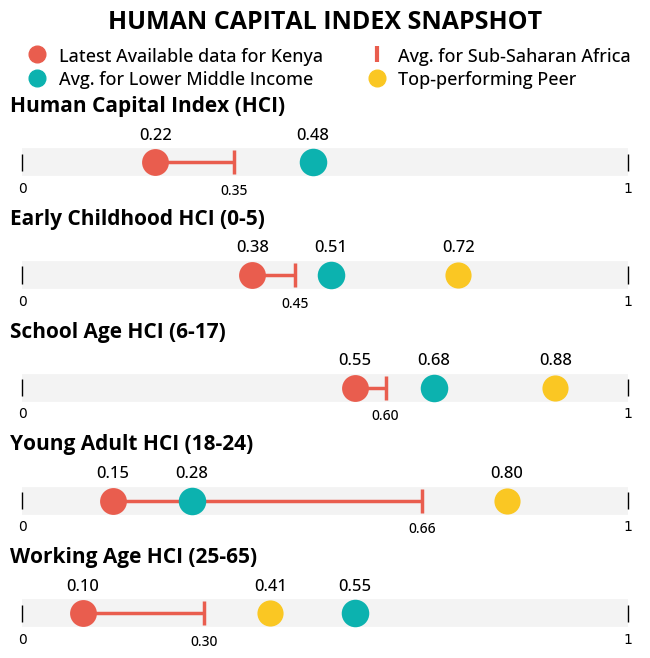

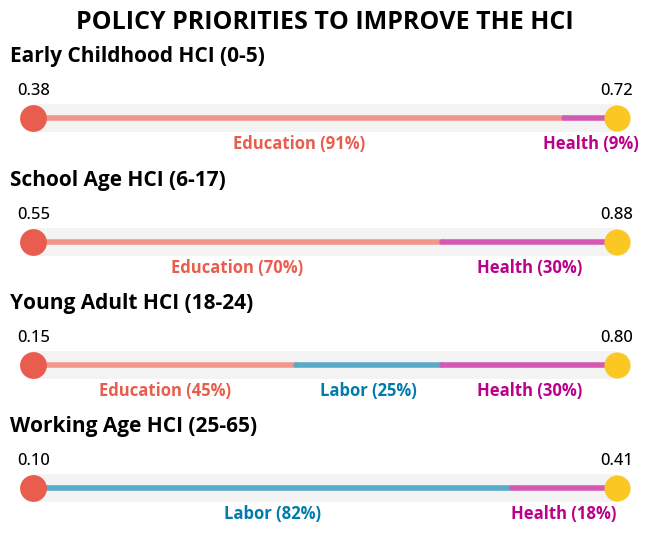

In [2]:
# -------------------------------------------------------------
# 1.  Prepare the parameter sets you want to stack
# -------------------------------------------------------------
cases = [
    dict(
        x_main=0.22, x_top95=52, x_region=0.35, x_income=0.48,
        components=generate_random_list(2),
        component_labels=("Education", "Health"),
        title="Human Capital Index (HCI)",
    ),
    dict(
        x_main=0.38, x_top95=0.72, x_region=0.45, x_income=0.51,
        components=[.91, .09],
        component_labels=("Education", "Health"),
        title="Early Childhood HCI (0-5)",
    ),
    dict( 
        x_main=0.55, x_top95=0.88, x_region=0.60, x_income=0.68,
        components=[.7, .3],
        component_labels=("Education", "Health"),
        title="School Age HCI (6-17)",
    ),
    dict(
        x_main=0.15, x_top95=0.80, x_region=0.66, x_income=0.28,
        components=[.45, .12+.09+.04, .3],
        component_labels=("Education", "Labor", "Health"),
        title="Young Adult HCI (18-24)",
    ),
    dict(
        x_main=0.1, x_top95=0.41, x_region=0.30, x_income=0.55,
        components=[.78+.03+.01, .18],
        component_labels=("Labor", "Health"),
        title="Working Age HCI (25-65)",
    ),
]

# -------------------------------------------------------------
# 2.  Create Figure for HCI Stages
# -------------------------------------------------------------
n = len(cases)
container_fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(7, 1.3*n),
    squeeze=False,
)
axes = axes.flatten()

for ax, params in zip(axes, cases):
    _, ax = plot_hci_stage(**params, ax=ax)  # ← your function
        
container_fig.suptitle("HUMAN CAPITAL INDEX SNAPSHOT", font=bold_font, fontsize=18)
container_fig = add_legend(container_fig)

container_fig.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.81)
container_fig.savefig(rf"{output}\HCI_stages.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")

# # Export individual rows
# i = 0
# for ax, params in zip(axes, cases):
#     _, ax = plot_hci_stage(**params, ax=ax)  # ← your function

#     # Now plot single hci stage
#     fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 1.3))
#     _, ax2 = plot_hci_stage(**params, ax=ax2)  # ← your function
#     fig2.savefig(rff"{output}\HCI_stages_{i}.jpg", dpi=600, bbox_inches='tight', pad_inches=.25)
#     i += 1

# -------------------------------------------------------------
# 3.  Create Decomposition Figure for HCI Stages
# -------------------------------------------------------------
cases = cases[1:]
n = len(cases)
container_fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(7, 1.3*n),
    squeeze=False,
)
axes = axes.flatten()

for ax, params in zip(axes, cases):
    _, ax = plot_two_line_decomposition(**params, ax=ax)  # ← your function

container_fig.suptitle("POLICY PRIORITIES TO IMPROVE THE HCI", font=bold_font, fontsize=18)
container_fig.tight_layout()
# container_fig.show()
plt.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.87)
container_fig.savefig(rf"{output}\stacked_two_line_decomposition.jpg", dpi=600, bbox_inches='tight', pad_inches=.25, edgecolor="black")


In [3]:
# -------------------------------------------------------------
# 4. Combine Figures
# -------------------------------------------------------------
from PIL import Image

# Open the two images
img1 = Image.open(rf"{output}\HCI_stages.jpg")
img2 = Image.open(rf"{output}\stacked_two_line_decomposition.jpg")

# Make sure they have the same width
assert img1.width == img2.width, "Images must have the same width"

# Create a new blank image with combined height
total_height = img1.height + img2.height - 200
result = Image.new("RGB", (img1.width, total_height))

# Paste images one below the other
result.paste(img1, (0, 0))
result.paste(img2, (0, img1.height - 150))

# Save or show the result
result.save("combined.jpg")